<a href="https://colab.research.google.com/github/profliuhao/CSIT599/blob/main/CSIT_599_Module_3_PyTorch_Tutorial_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
This is a PyTorch Tutorial for CSIT 599 Deep Learning.
There's already a bunch of great tutorials that you might want to check out, and in particular [this tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).
This tutorial covers a lot of the same material. If you're familiar with PyTorch basics, you might want to skip ahead to the PyTorch Advanced section.

First, let's import some things and define a useful plotting function

In [ ]:
#@title imports and define `plot`

import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.notebook import tqdm # Use tqdm.notebook for Colab/Jupyter compatibility
import time


import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import torch.nn.functional as F

def plot(xs, ys, xlim=(-3, 3), ylim=(-3, 3)):
  fig, ax = plt.subplots()
  ax.plot(xs, ys, linewidth=5)
  # ax.set_aspect('equal')
  ax.grid(True, which='both')

  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)

For GPU support, go to `Runtime > Change runtime type`.

# Review: Numpy

Numpy arrays are objects that allow you to store and manipulate matrices.

In [ ]:
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([[8, 0, 7], [3, 0, 1]])
z = np.random.rand(3, 2, 3)
print(f"x, shape={x.shape}:\n{x}\n")
print(f"y, shape={y.shape}:\n{y}\n")
print(f"z, shape={z.shape}:\n{z}\n")

x, shape=(6,):
[1 2 3 4 5 6]

y, shape=(2, 3):
[[8 0 7]
 [3 0 1]]

z, shape=(3, 2, 3):
[[[0.72269672 0.78853956 0.55441365]
  [0.56474253 0.42507126 0.92261915]]

 [[0.89659574 0.21435818 0.47548781]
  [0.64251607 0.63059315 0.4387461 ]]

 [[0.51216535 0.47794223 0.2021454 ]
  [0.73251574 0.23840448 0.79316455]]]



You can index into Numpy arrays similar to Python lists (with integers or slices), with the addition of being able to specify indices for multiple dimensions.

In [ ]:
x = np.arange(1, 21, 1).reshape(4, 5)
print(x)
print()
print(x[2]) # Single index
print(x[2, 3]) # Indices for multiple dimensions
print(x[2:4, 3]) # Combining integer index and slice

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]

[11 12 13 14 15]
14
[14 19]


## Numpy arithmetic and broadcasting

You can add/subtract/multiple/divide numpy arrays, as long as their dimensions match:

In [ ]:
a = np.ones((2, 3))
print(a)
print("+")
print(y)
print("=")
print(a + y)

[[1. 1. 1.]
 [1. 1. 1.]]
+
[[8 0 7]
 [3 0 1]]
=
[[9. 1. 8.]
 [4. 1. 2.]]


You can also sometimes do arithmetic operations on arrays whose dimensions _don't_ match exactly. Whenever possible, values will be "copied" so that the dimensions match:

In [ ]:
print(f"3\n*\n{a}\n=\n{3*a}\n")

a = np.array([1, 2, 3])
print(f"{a}\n+\n{z}\n=\n{a+z}")

3
*
[[1. 1. 1.]
 [1. 1. 1.]]
=
[[3. 3. 3.]
 [3. 3. 3.]]

[1 2 3]
+
[[[0.72269672 0.78853956 0.55441365]
  [0.56474253 0.42507126 0.92261915]]

 [[0.89659574 0.21435818 0.47548781]
  [0.64251607 0.63059315 0.4387461 ]]

 [[0.51216535 0.47794223 0.2021454 ]
  [0.73251574 0.23840448 0.79316455]]]
=
[[[1.72269672 2.78853956 3.55441365]
  [1.56474253 2.42507126 3.92261915]]

 [[1.89659574 2.21435818 3.47548781]
  [1.64251607 2.63059315 3.4387461 ]]

 [[1.51216535 2.47794223 3.2021454 ]
  [1.73251574 2.23840448 3.79316455]]]


This is called [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html), and it has many benefits:
- More concise code
- Duplicated values aren't explicitly created/stored in memory
- Repeated operations are optimized to run faster

## Axes

Numpy arrays have **axes**, which are like the "directions" along which you can do things. For example, in 2D:

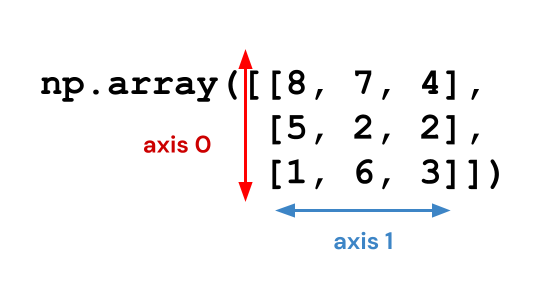

In [ ]:
x = np.array([[8, 7, 4], [5, 2, 2], [1, 6, 3]])
print(np.sum(x))
print(np.sum(x, axis=0))
print(np.sum(x, axis=1))
# print()
print(np.max(x))
print(np.max(x, axis=0))
print(np.max(x, axis=1))

38
[14 15  9]
[19  9 10]
8
[8 7 4]
[8 5 6]


More generally, you can think of an axis as the index of one of the values in the array's `shape`. If you do a reduction operation (e.g. sum, max) on a certain axis, that axis will disappear from the array's shape:

In [ ]:
z = np.random.randint(10, size=(3, 2, 4, 5))
print(np.sum(z, axis=2).shape)
print(np.sum(z, axis=(0, 2)).shape)

(3, 2, 5)
(2, 5)


## Shapes and reshaping

Be careful about the shape of your numpy arrays, especially when you're working with vectors (where one of the dimensions is 1)!

In [ ]:
# These two are different things!
x = np.random.randint(10, size=(10,))
y = np.random.randint(10, size=(10, 1))
print(x)
print(y)

[3 8 4 0 6 5 6 0 2 4]
[[4]
 [3]
 [5]
 [6]
 [2]
 [1]
 [1]
 [3]
 [9]
 [9]]


In [ ]:
# If you multiply a shape (n,) array with a (n,1) array, you actually get a shape (n,n) matrix:
print(x)
print("*")
print(y)
print("=")
print(x * y)

[3 8 4 0 6 5 6 0 2 4]
*
[[4]
 [3]
 [5]
 [6]
 [2]
 [1]
 [1]
 [3]
 [9]
 [9]]
=
[[12 32 16  0 24 20 24  0  8 16]
 [ 9 24 12  0 18 15 18  0  6 12]
 [15 40 20  0 30 25 30  0 10 20]
 [18 48 24  0 36 30 36  0 12 24]
 [ 6 16  8  0 12 10 12  0  4  8]
 [ 3  8  4  0  6  5  6  0  2  4]
 [ 3  8  4  0  6  5  6  0  2  4]
 [ 9 24 12  0 18 15 18  0  6 12]
 [27 72 36  0 54 45 54  0 18 36]
 [27 72 36  0 54 45 54  0 18 36]]


In [ ]:
# If your intention is to multiply the two vectors element-wise, you need to reshape one of them first!
x_reshaped = x.reshape(-1, 1) # -1 means "infer this dimension"
print()
print(x_reshaped)
print("*")
print(y)
print("=")
print(x_reshaped * y)


[[3]
 [8]
 [4]
 [0]
 [6]
 [5]
 [6]
 [0]
 [2]
 [4]]
*
[[4]
 [3]
 [5]
 [6]
 [2]
 [1]
 [1]
 [3]
 [9]
 [9]]
=
[[12]
 [24]
 [20]
 [ 0]
 [12]
 [ 5]
 [ 6]
 [ 0]
 [18]
 [36]]


It's pretty common to have to add/remove an axis from a numpy array, so there's some useful syntax to do this:

In [ ]:
# Removing axis/axes from an array
print(y.shape)
print(y.reshape(10).shape)
print(y.squeeze().shape)

(10, 1)
(10,)
(10,)


In [ ]:
# Adding axis/axes to an array
print(x.shape)
# print(x.reshape(-1, 1).shape)
print(x[:, np.newaxis].shape)
print(x[:, None].shape) # Same as above, but not as readable

(10,)
(10, 1)
(10, 1)


The benefits of `squeeze` and `np.newaxis` become clearer when you're working with more dimensions:

In [ ]:
a = np.random.randint(10, size=(10, 1, 4, 1, 1, 6, 2))
print(a.shape)
print(a.reshape(10, 4, 1, 6, 2).shape)
print(a.squeeze((1, 3)).shape)

(10, 1, 4, 1, 1, 6, 2)
(10, 4, 1, 6, 2)
(10, 4, 1, 6, 2)


In [ ]:
b = np.random.randint(10, size=(10, 4, 2, 7, 8, 9))
print(b.shape)
print(b.reshape(10, 1, 4, 1, 2, 7, 8, 9).shape)
print(b[:, np.newaxis, :, np.newaxis, ...].shape) # ... means "rest of dimensions"

(10, 4, 2, 7, 8, 9)
(10, 1, 4, 1, 2, 7, 8, 9)
(10, 1, 4, 1, 2, 7, 8, 9)


## Array Multiplication

Numpy has two multiplication operators: `*` and `@`.
- `*` does **element-wise** multiplication.
- `@` does **matrix** multiplication.

In [ ]:
matrix = np.random.randint(10, size=(5, 5))
row_vec = np.random.randint(10, size=(5,))
col_vec = row_vec.reshape(5, 1)

# Outer product
print(col_vec)
print("*")
print(row_vec)
print("=")
print(col_vec * row_vec)

[[8]
 [3]
 [6]
 [7]
 [7]]
*
[8 3 6 7 7]
=
[[64 24 48 56 56]
 [24  9 18 21 21]
 [48 18 36 42 42]
 [56 21 42 49 49]
 [56 21 42 49 49]]


In [ ]:
# Dot product
print(row_vec)
print("@")
print(col_vec)
print("=")
# print((row_vec @ col_vec)) # Result will be a shape (1,) array
# print(row_vec.dot(col_vec).squeeze()) # Same as above
print(row_vec @ col_vec.squeeze()) # Works on arrays with same shape too (to get scalar)

[8 3 6 7 7]
@
[[8]
 [3]
 [6]
 [7]
 [7]]
=
207


Below are some other common Numpy operations you'll probably find useful at some point in this class:

In [ ]:
# transpose: reorders the axes of the array
z = np.random.rand(28, 28, 3)
z_transposed = z.transpose((2, 0, 1))
print("Orig shape:", z.shape)
print("New shape: ", z_transposed.shape)


Orig shape: (28, 28, 3)
New shape:  (3, 28, 28)


# PyTorch Basics

PyTorch is built around _tensors_, which are very similar to numpy arrays. You can do many of the same operations in PyTorch; everything we covered above applies to PyTorch tensors as well!

In [ ]:
x = torch.zeros(2, 3)
y = torch.ones(2, 3)
z = x + y

print(x)
print("+")
print(y)
print("=")
print(z)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
+
tensor([[1., 1., 1.],
        [1., 1., 1.]])
=
tensor([[1., 1., 1.],
        [1., 1., 1.]])


Reduction operations work the same way as they do in Numpy, except we use the argument `dim` instead of `axis`:

In [ ]:
print(torch.sum(z, dim=1))
print(torch.sum(z, dim=0))

tensor([3., 3.])
tensor([2., 2., 2.])


Also like Numpy, PyTorch will try to broadcast operations:

In [ ]:
x = torch.ones((3, 1))
y = torch.ones((1, 3))
z = x + y

print(x)
print("+")
print(y)
print("=")
print(z)

tensor([[1.],
        [1.],
        [1.]])
+
tensor([[1., 1., 1.]])
=
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])


### Moving between numpy and PyTorch

In [ ]:
x_np = np.random.randn(2, 3)
print(x_np)

[[-1.73870878 -2.02288704 -0.44810012]
 [ 0.61386278  1.21955349  1.44155964]]


Use `torch.from_numpy` to convert from numpy array -> PyTorch tensor. The resulting tensor shares the same memory as the numpy array:

In [ ]:
x = torch.from_numpy(x_np)
print(x)

x_np[:] = 0
print(x)

tensor([[-1.7387, -2.0229, -0.4481],
        [ 0.6139,  1.2196,  1.4416]], dtype=torch.float64)
tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)


By default, numpy arrays are float64. You'll probably want to convert arrays to float32, as most tensors in pytorch are float32.

In [ ]:
x = torch.from_numpy(x_np).to(torch.float32)
print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.]])


Use `.numpy()` to convert from PyTorch tensor -> numpy array:

In [ ]:
print(x.numpy())

[[0. 0. 0.]
 [0. 0. 0.]]


## Neural-Network specific functions
PyTorch has a bunch of built-in funcitons.
See [the docs](https://pytorch.org/docs/stable/torch.html) for a full list.

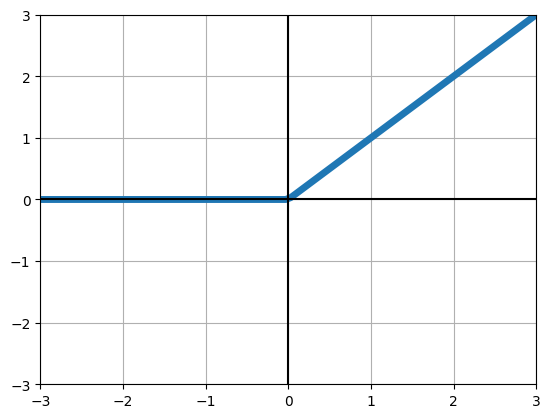

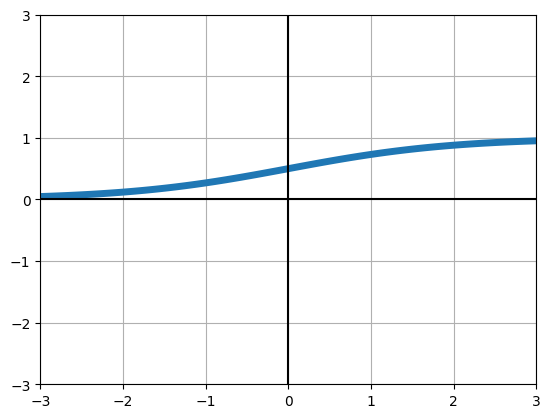

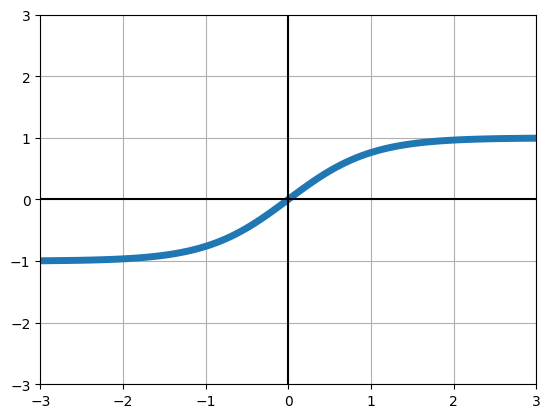

In [ ]:
# Activation functions
xs = torch.linspace(-3, 3, 100)
ys = torch.relu(xs)
plot(xs.numpy(), ys.numpy())
ys = torch.sigmoid(xs)
plot(xs.numpy(), ys.numpy())
ys = torch.tanh(xs)
plot(xs.numpy(), ys.numpy())

In [ ]:
x = torch.tensor([[2, 3.5],
                  [4, 4]])
torch.softmax(x, dim=-1) # for predicting probabilities, do softmax along last dimension (by row)

tensor([[0.1824, 0.8176],
        [0.5000, 0.5000]])

## Automatic differentiation

Given some loss function
$$L(\vec x, \vec y) = ||2 \vec x + \vec y||_2^2$$
we want to evaluate
$$\frac{\partial L}{\partial \vec x}$$
and
$$\frac{\partial L}{\partial \vec y}$$

In [ ]:
# By default, tensors have requires_grad=False. Need to specify if you want
# the gradients for a tensor!
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape, requires_grad=True)

PyTorch makes this easy by having tensors keep track of their data...

In [ ]:
x.data

tensor([1., 2., 3.])

...and their gradient:

In [ ]:
print(x.grad)

None


However, right now `x` has no gradient because it does not know what loss it must be differentiated with respect to.
Below, we define the loss.

In [ ]:
loss = ((2 * x + y)**2).sum()
print(loss)

tensor(83., grad_fn=<SumBackward0>)


Notice the `grad_fn` property on the tensor. We can trace our way back through these grad functions to see the whole computation graph:

In [ ]:
grad_fns = [(loss.grad_fn, 0)]
curr_level = 0
lines = []
while grad_fns:
    prev_level = curr_level
    fn, curr_level = grad_fns.pop()
    if curr_level != prev_level:
        print("---")
    print(fn.name())
    for next_fn, _ in fn.next_functions:
        if next_fn:
            grad_fns.append((next_fn, curr_level + 1))

SumBackward0
---
PowBackward0
---
AddBackward0
---
torch::autograd::AccumulateGrad
MulBackward0
---
torch::autograd::AccumulateGrad


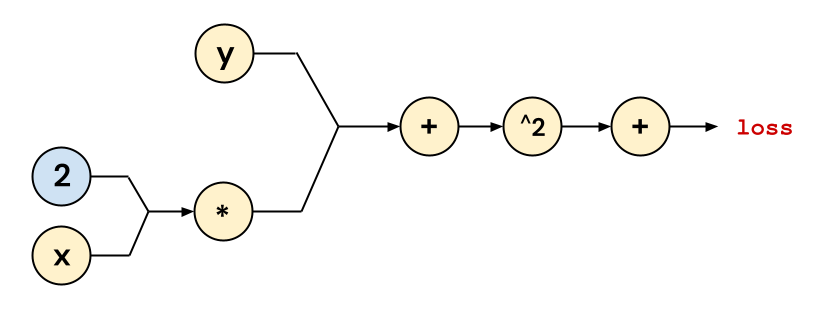

Each of the yellow nodes above has a `.grad` property which will store the gradients accumulated during backprop.

To perform backprop, call `.backward()` on the loss:

In [ ]:
loss.backward()

Now we see that the gradients are populated!

In [ ]:
print(x.grad)
print(y.grad)

tensor([12., 20., 28.])
tensor([ 6., 10., 14.])


### gradients accumulate
Gradients accumulate, so if you call backwards twice...

In [ ]:
loss = ((2 * x + y)**2).sum()
loss.backward()

...you'll get twice the gradient.

In [ ]:
print(x.grad)
print(y.grad)

tensor([24., 40., 56.])
tensor([12., 20., 28.])


### multiple losses

This accumulation makes it easy to add gradients from different losses, which might not even use the same parameters. For example, this loss is only a function of `x`....

In [ ]:
other_loss = (x**2).sum()
other_loss.backward()

...and so only `x.grad` changes.

In [ ]:
print(x.grad)
print(y.grad)

tensor([26., 44., 62.])
tensor([12., 20., 28.])


### stopping and starting gradients

If you don't specify `required_grad=True`, the gradient will always be `None`.

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape)
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)

tensor([12., 20., 28.])
None


You can turn `required_grad` back on after initializing a tensor.

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape)
y.requires_grad = True
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)

tensor([12., 20., 28.])
tensor([ 6., 10., 14.])


You can cut a gradient by calling `y.detach()`, which will return a new tensor with `required_grad=False`. Note that `detach` is not an in-place operation! You would want this during evaluation.

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape, requires_grad=True)
y_detached = y.detach()
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)
print(y_detached.grad)
print(y.detach())

tensor([12., 20., 28.])
tensor([ 6., 10., 14.])
None
tensor([1., 1., 1.])


A few things to watch out for:
- You can't do any in-place operations on a tensor that has `requires_grad=True`. (This prevents you from inadvertently mutating it in a way that isn't tracked for backprop purposes.)

- You also can't convert a tensor with `requires_grad=True` to numpy (for the same reason as above). Instead, you need to detach it first, e.g. `y.detach().numpy()`.

- Even though `y.detach()` returns a new tensor, that tensor occupies the same memory as `y`. Unfortunately, PyTorch lets you make changes to `y.detach()` or `y.detach.numpy()` which will affect `y` as well! If you want to safely mutate the detached version, you should use `y.detach().clone()` instead, which will create a tensor in new memory.

RL Connection: You would want to be doing simulator-related tasks with numpy, convert to torch when doing model-related tasks, and convert back to feed output into simulator.

## Example: Regression Task
Let's train a simple neural network to model a sine wave. This is our target:

torch.Size([100, 1])


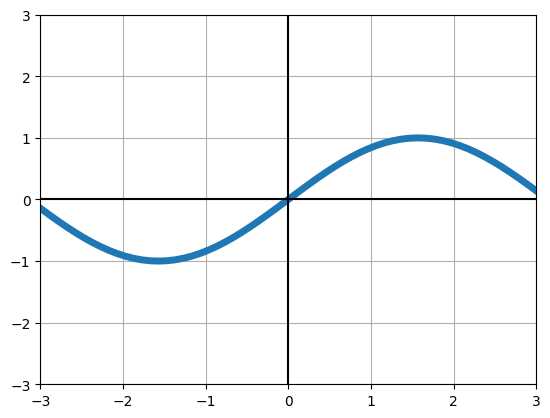

In [ ]:
x = torch.linspace(-5, 5, 100).view(100, 1)
print(x.shape)
y_target = torch.sin(x)
loss_fn = nn.MSELoss()
plot(x, y_target)

### Modules
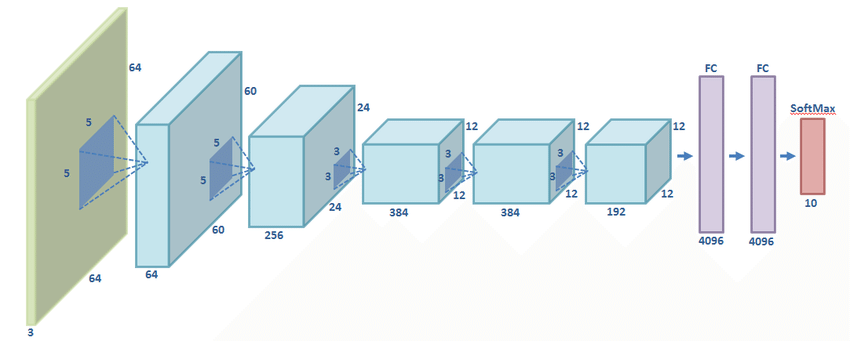

`nn.Module` represents the building blocks of a computation graph.
For example, in typical pytorch code, each convolution block above is its own module, each fully connected block is a module, and the whole network itself is also a module.
Modules can contain modules within them.
All the classes inside of `torch.nn` are instances `nn.Modules`.
Below is an example definition of a module:

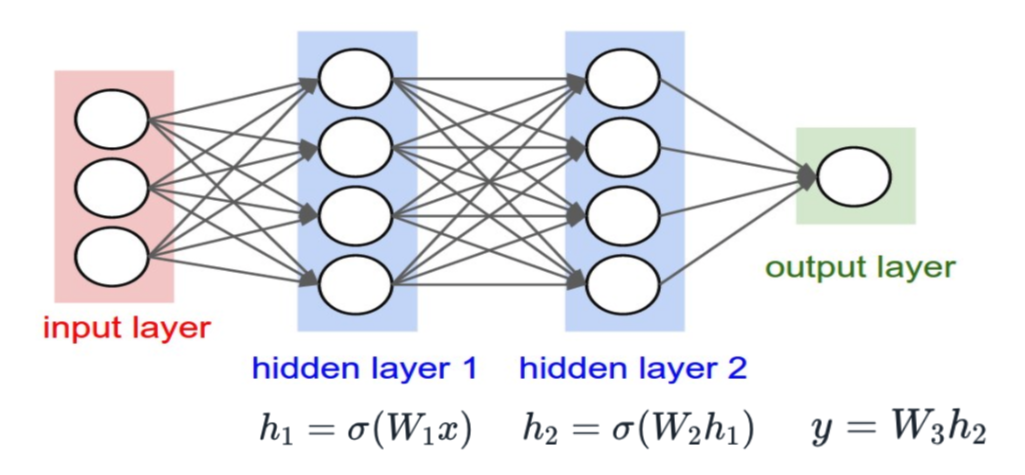

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.net = nn.Sequential()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The main function that you need to implement is the `forward` function.
Otherwise, it's a normal Python object:

In [ ]:
net = Net(input_size=1, output_size=1)
print(net)

Net(
  (net): Sequential()
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


To evaluate a neural network on some input, you pass an input through a module by calling it directly. In particular, don't call `net.forward(x)`.

In [ ]:
y = net(x)
# net.forward(x) <- DON't DO THIS
print(y.shape)

torch.Size([100, 1])


Let's visualize what the network looks like before training.

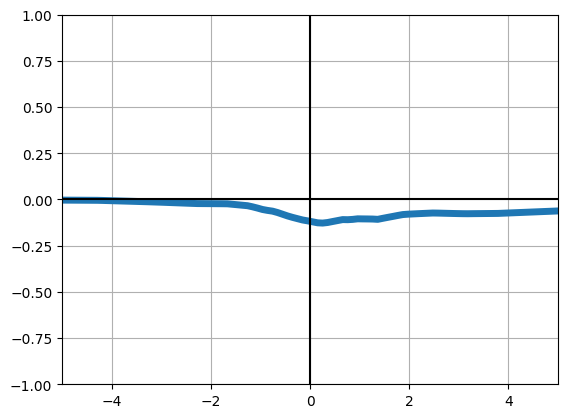

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

Let's look into what the `nn.Module` is doing...

In the `__init__` function, any variable that you assign to `self` that is also a module will be automatically added as a sub-module. The parameters of a module (and all sub-modules) can be accessed through the `parameters()` or `named_parameters()` functions:

In [ ]:
for name, p in net.named_parameters():
  print(name, p.shape)

fc1.weight torch.Size([32, 1])
fc1.bias torch.Size([32])
fc2.weight torch.Size([32, 32])
fc2.bias torch.Size([32])
fc3.weight torch.Size([1, 32])
fc3.bias torch.Size([1])


These parameters will automatically have their gradients stored (i.e. `requires_grad=True`)

In [ ]:
print(net.fc1.bias.grad)

None


WARNING: if you want to have a list of modules use
```
def __init__(self, network1, network2):
  self.list = nn.ModuleList([network1, network 2])
```
and **not**
```
def __init__(self, network1, network2):
  self.list = [network1, network 2]
```
In the latter case, `network1` and `network2` won't be added as sub-modules and their gradients won't be tracked.

The output of the module is just a tensor. We can perform operations on the tensor like before to automatically compute derivatives.
For example, below, we minimize the sum-of-squared-errors.

In [ ]:
loss = ((y - y_target)**2).sum()
loss.backward()

We can manually update the parameters by adding the gradient (times a negative learning rate) and zero'ing out the gradients to prevent gradient accumulation.

In [ ]:
for p in net.parameters():
  p.data.add_(-0.001 * p.grad)
  p.grad.data.zero_()

And we can do this in a loop to train our network!

In [ ]:
for _ in range(100):
  y = net(x)
  loss = ((y - y_target)**2).sum()
  loss.backward()
  for p in net.parameters():
    p.data.add_(- 0.001 * p.grad)
    p.grad.data.zero_()

Sure enough, our network learns something close to a sine wave.

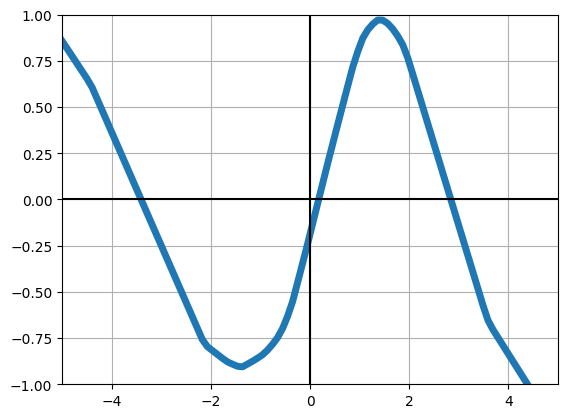

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

PyTorch has functions that can do a lot of these functions (i.e. loss) for you!

### Loss Functions
PyTorch has a bunch of built in loss functions, which are just other modules that you can pass your data through.

In [ ]:
loss_fn = nn.MSELoss()
loss_fn(torch.tensor([1.4, 3.3, 1.9]), torch.tensor([1, 3, 2]))

tensor(0.0867)

In [ ]:
net = Net(input_size=1, output_size=1)

for _ in range(1000):
  y = net(x)
  loss = loss_fn(y, y_target)
  loss.backward()
  for p in net.parameters():
    p.data.add_(- 0.001 * p.grad)
    p.grad.data.zero_()

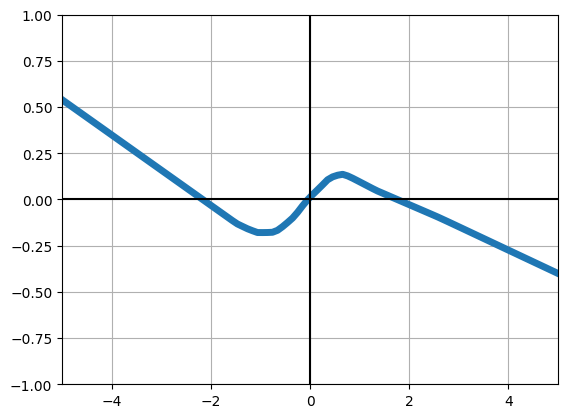

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

### Optimizers

We can also use the `optim` package for built-in optimizers instead of implementing gradient descent ourselves.

In [ ]:
from torch import optim

net = Net(input_size=1, output_size=1)

optimizer = optim.Adam(net.parameters(), lr=1e-3) # or SGD, RMSProp

x = torch.linspace(-5, 5, 100).view(-1, 1)
y = net(x)
y_target = torch.sin(x)
loss_fn = nn.MSELoss()

Here's the network before training

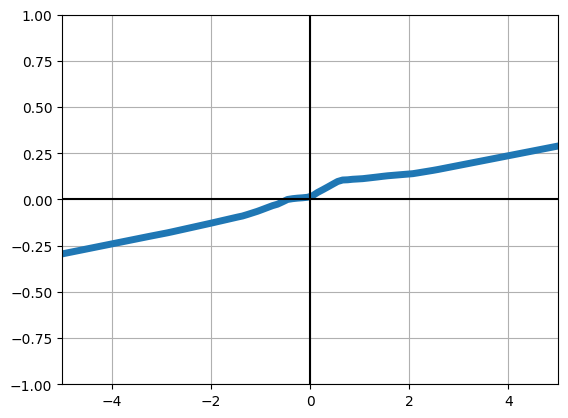

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

and here's how you can use the optimize to train the network.
Note that we call `zero_grad` _before_ calling `loss.backward()`, and then we just call `optimizer.step()`. This `step` function will take care of updating all the parameters that were passed to that optimizer's constructor.

In [ ]:
for _ in range(100):
  y = net(x)
  loss = loss_fn(y, y_target)

  optimizer.zero_grad() # zero's out gradients
  loss.backward() # populate gradients
  optimizer.step() # update each parameter via gradient descent

And we see that this trained a network quite well:

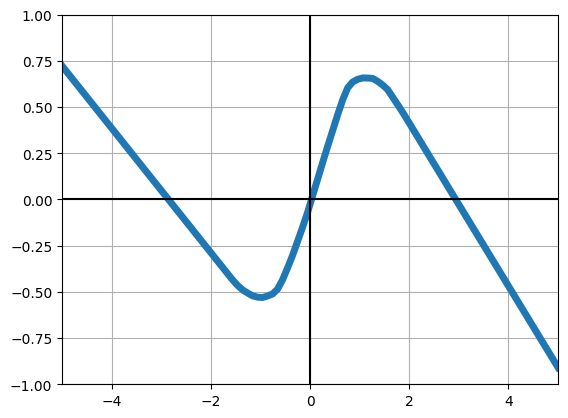

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

To summarize, here's what we did:

- Defined a class for our neural network (subclass of `nn.Module`)
- Specified a loss function (MSE loss) and optimizer (Adam) --> make sure to pass all model parameters (especially for multimodal)
- Performed training by doing the following in a loop:
    - Make prediction
    - Compute loss
    - Zero the stored gradients
    - Backprop the loss with `.backward()`
    - Update the weights by taking a step of gradient descent

### GPU support

A crucial feature of PyTorch is the support of GPUs, short for Graphics Processing Unit. A GPU can perform many thousands of small operations in parallel, making it very well suitable for performing large matrix operations in neural networks. When comparing GPUs to CPUs, we can list the following main differences (credit: [Kevin Krewell, 2009](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/))

<center style="width: 100%"><img src="comparison_CPU_GPU.png" width="700px"></center>

CPUs and GPUs have both different advantages and disadvantages, which is why many computers contain both components and use them for different tasks. In case you are not familiar with GPUs, you can read up more details in this [NVIDIA blog post](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/) or [here](https://www.intel.com/content/www/us/en/products/docs/processors/what-is-a-gpu.html).

GPUs can accelerate the training of your network up to a factor of $100$ which is essential for large neural networks. PyTorch implements a lot of functionality for supporting GPUs (mostly those of NVIDIA due to the libraries [CUDA](https://developer.nvidia.com/cuda-zone) and [cuDNN](https://developer.nvidia.com/cudnn)). First, let's check whether you have a GPU available:

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


If you have a GPU on your computer but the command above returns False, make sure you have the correct CUDA-version installed. The `dl2024` environment comes with the CUDA 12.4, which is selected for the Snellius supercomputer. Please change it if necessary. On Google Colab, make sure that you have selected a GPU in your runtime setup (in the menu, check under `Runtime -> Change runtime type`).

By default, all tensors you create are stored on the CPU. We can push a tensor to the GPU by using the function `.to(...)`, or `.cuda()`. However, it is often a good practice to define a `device` object in your code which points to the GPU if you have one, and otherwise to the CPU. Then, you can write your code with respect to this device object, and it allows you to run the same code on both a CPU-only system, and one with a GPU. Let's try it below. We can specify the device as follows:

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


Now let's create a tensor and push it to the device:

In [ ]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In case you have a GPU, you should now see the attribute `device='cuda:0'` being printed next to your tensor. The zero next to cuda indicates that this is the zero-th GPU device on your computer. PyTorch also supports multi-GPU systems, but this you will only need once you have very big networks to train (if interested, see the [PyTorch documentation](https://pytorch.org/docs/stable/distributed.html#distributed-basics)). We can also compare the runtime of a large matrix multiplication on the CPU with a operation on the GPU:

In [ ]:
x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # First operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 1.94299s
GPU time: 0.07868s


In [ ]:
# Checking whether GPU is available
print(torch.cuda.is_available())

# Initialize a tensor on GPU instead of CPU
device = torch.device("cuda")
y = torch.ones((2, 3), device=device)
print(y)

True
tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')


You can only do operations on tensors if they're on the same device. The code below errors because one tensor is on CPU while the other is on GPU:

In [ ]:
device = torch.device("cuda")
x = torch.zeros((2, 3))
y = torch.ones((2, 3), device=device)
# z = x + y

You can move a tensor to the GPU by using the `to` function.

In [ ]:
x = x.to(device)
z = x + y
print(z)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')


You can't convert tensors on a GPU into numpy arrays directly. This will error:

In [ ]:
# z.numpy()

Instead, you will need to first move the tensor to CPU before converting to numpy.

In [ ]:
z_cpu = z.to('cpu')
z_cpu.numpy()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

## Full training example

Now let's do the same training example end-to-end, with GPU support added in:

### Training the model

Using device: cuda


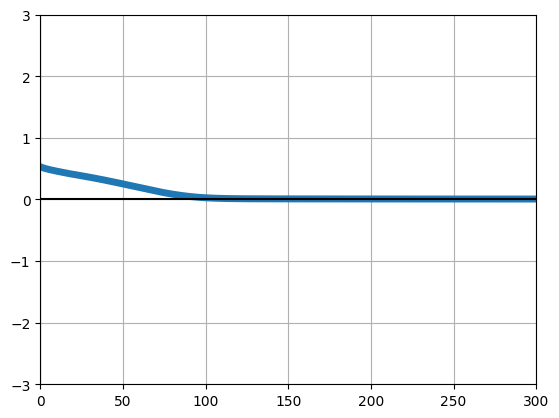

In [ ]:
# Define the data
x = torch.linspace(-5, 5, 100).view(-1, 1)
y_target = torch.sin(x)

net = Net(input_size=1, output_size=1)
########## (NEW) ##########
# Set up GPU device (if available) and move model and targets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net = net.to(device)
y_target = y_target.to(device)
########## (NEW) ##########

optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
losses = []

for _ in range(300):
    ########## (NEW) ##########
    x = x.to(device)
    # y_target = y_target.to(device)
    ########## (NEW) ##########
    y = net(x)
    loss = loss_fn(y, y_target)
    losses.append(loss.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plot(range(300), losses, xlim=(0, 300))

### Evaluating the model

Notice the `.eval()` and `with torch.no_grad()` -- make sure to include these whenever making predictions at test time!

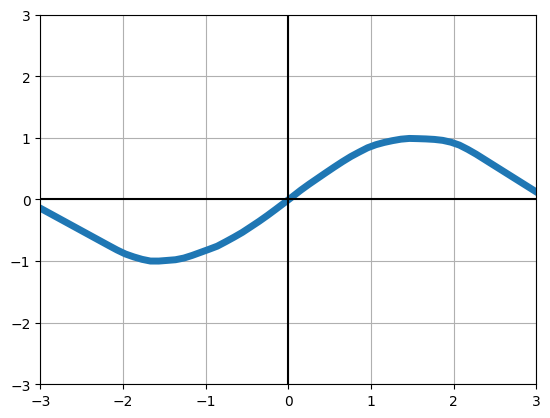

In [ ]:
net.eval() # Switches the network to evaluation mode, disabling things like dropout and batch norm
with torch.no_grad(): # Temporarily disables all `requires_grad` within the enclosed block
    y = net(x)
plot(x.cpu().numpy(), y.cpu().numpy())

### Saving (and loading) model weights

Once you're done training, you'll probably want to save the weights of your model for later use.

In [ ]:
# Save a dictionary of parameter names and their values
PATH = "checkpoint.pt"
torch.save(net.state_dict(), PATH)
# saves everything including parameters and other state values (i.e. batch norm mean)

In [ ]:
# Later: Initialize a new model and load the saved state dict
new_model = Net(input_size=1, output_size=1) # with same architecture
new_model.to(device)
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

for (name1, val1), (name2, val2) in zip(net.state_dict().items(), new_model.state_dict().items()):
    assert name1 == name2 and torch.equal(val1, val2), f"{name1} and {name2} states differ!"

## Building a simple neural network

### The model

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. We import it below:

In [ ]:
import torch.nn as nn

Additionally to `torch.nn`, there is also `torch.nn.functional`. It contains functions that are used in network layers. This is in contrast to `torch.nn` which defines them as `nn.Modules` (more on it below), and `torch.nn` actually uses a lot of functionalities from `torch.nn.functional`. Hence, the functional package is useful in many situations, and so we import it as well here.

In [ ]:
import torch.nn.functional as F

#### nn.Module

In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [ ]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

The forward function is where the computation of the module is taken place, and is executed when you call the module (`nn = MyModule(); nn(x)`). In the init function, we usually create the parameters of the module, using `nn.Parameter`, or defining other modules that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted.

#### Simple classifier
We can now make use of the pre-defined modules in the `torch.nn` package, and define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer.

In PyTorch, we can define this as follows:

In [ ]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [ ]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Printing the model lists all submodules it contains. The parameters of a module can be obtained by using its `parameters()` functions, or `named_parameters()` to get a name to each parameter object. For our small neural network, we have the following parameters:

In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


Each linear layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`. The tanh activation function does not have any parameters.

Another example below:

In [ ]:
# Create an instance of the neural network
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 8, bias=False)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = SimpleNet()

In [ ]:
print(net)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Prepare some dummy data and labels
data = torch.tensor([[1., 2.], [3., 4.]], dtype=torch.float32)
labels = torch.tensor([[0.], [1.]], dtype=torch.float32)

# Train the neural network
for epoch in range(500):
    # Forward pass
    outputs = net(data)
    loss = criterion(outputs, labels)

    # IMPORTANT: Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()
    optimizer.step()

    # Print the loss for this epoch
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{500}], Loss: {loss.item():.4f}")


SimpleNet(
  (fc1): Linear(in_features=2, out_features=8, bias=False)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
Epoch [100/500], Loss: 0.2608
Epoch [200/500], Loss: 0.2502
Epoch [300/500], Loss: 0.2500
Epoch [400/500], Loss: 0.2500
Epoch [500/500], Loss: 0.2500


## PyTorch Datasets and DataLoaders

Datasets and DataLoaders are essential components for handling data in PyTorch. A Dataset is a collection of data, and a DataLoader helps to efficiently load the data in batches during training.

In this example, we'll use the FashionMNIST dataset, which contains 60,000 training images and 10,000 testing images of 10 different clothing items.

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Define data transformations
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# Create DataLoaders for train and test datasets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=512, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=512, shuffle=False, num_workers=2
)

print("Num training examples: {}".format(len(train_dataset)))
print("Num test examples: {}".format(len(test_dataset)))


# List of class labels
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.32MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.7MB/s]

Num training examples: 60000
Num test examples: 10000


## Visualizing Examples from the FashionMNIST Dataset

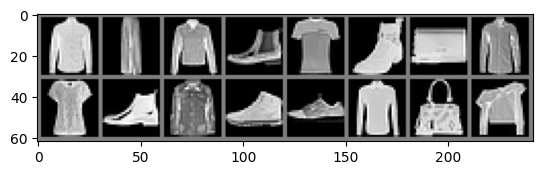

Shirt -- Trouser -- Coat -- Ankle boot -- T-shirt/top -- Ankle boot -- Bag -- Shirt
T-shirt/top -- Ankle boot -- Coat -- Ankle boot -- Sneaker -- Shirt -- Bag -- Shirt


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images in a grid along with their labels
imshow(torchvision.utils.make_grid(images[:16]))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8)))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8,16)))

With the dataset loaded and the DataLoader created, we can now train our neural network using the FashionMNIST dataset. Let's modify our previous SimpleNet example to handle 28x28 images and 10 output classes.

## Training on the CPU = Slow!

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm # Use tqdm.notebook for Colab/Jupyter compatibility


# Define the neural network for FashionMNIST
class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network
net = FashionMNISTNet()
print(net)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Train the neural network using the FashionMNIST dataset
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    avg_loss = running_loss / (i + 1)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
print("Training finished.")

FashionMNISTNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.6931
Epoch [2/5], Loss: 0.6678
Epoch [3/5], Loss: 0.5679
Epoch [4/5], Loss: 0.5082
Epoch [5/5], Loss: 0.4699
Training finished.


## Training on the GPU = Faster!

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm # Use tqdm.notebook for Colab/Jupyter compatibility


# Define the neural network for FashionMNIST
class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# IMPORTANT CODE BELOW
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create an instance of the neural network
net = FashionMNISTNet()
print(net)

# Move the model to the GPU if available
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Train the neural network using the FashionMNIST dataset
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):

        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    avg_loss = running_loss / (i + 1)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
print("Training finished.")

Using device: cuda
FashionMNISTNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.6081
Epoch [2/5], Loss: 0.6619
Epoch [3/5], Loss: 0.5692
Epoch [4/5], Loss: 0.5124
Epoch [5/5], Loss: 0.4694
Training finished.


Now that we have trained our neural network, let's evaluate its performance on the test dataset.

In [ ]:
# Test the neural network
correct = 0
total = 0

# Set the model to evaluation mode
net.eval()

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:

        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Update the total number of samples and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 80.15%


Not bad!

Let's inspect number of total parameters and training parameters in the model:

In [ ]:
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


116,234 total parameters.
116,234 training parameters.


Now that we have a trained model, if we want to adapt the model to another dataset with only 5 classes, we can freeze earlier layers and only train on the last fully-connected layer.

In [ ]:
# Freeze earlier layers
for param in net.parameters():
    param.requires_grad = False

n_inputs = net.fc3.in_features
n_classes = 5
net.fc3 = nn.Linear(n_inputs, n_classes)
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

115,909 total parameters.
325 training parameters.


## Pre-trained weights

PyTorch has many pretrained models we can use. All of these models have been trained on Imagenet which consists of millions of images across 1000 categories. We want to freeze the early layers of these pretrained models and replace the classification module with our own.


PyTorch API for using pre-trained weights: https://pytorch.org/vision/stable/models.html

The approach for using a pre-trained image recognition model is well-established:

1. Load in pre-trained weights from a network trained on a large dataset
2. Freeze all the weights in the lower (convolutional) layers
    * Layers to freeze can be adjusted depending on similarity of task to large training dataset
3. Replace the classifier (fully connected) part of the network with a custom classifier
    * Number of outputs must be set equal to the number of classes
4. Train only the custom classifier (fully connected) layers for the task
    * Optimizer model classifier for smaller dataset


We will demonstrate an example of loading a pre-trained Resnet model.

In [ ]:
from torchvision import models

model = models.resnet50(pretrained=True)

print(model)

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 